In [ ]:
# Daily sales
## Import necessary libraries
import warnings
warnings.filterwarnings("ignore")
# sales_weather_pipeline.py
import pandas as pd
import numpy as np
from datetime import time
import pytz
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

# ───────────────────────────────────────────────────────────────────────────────
# 1) CONFIGURE YOUR LOCAL FILE PATHS
# ───────────────────────────────────────────────────────────────────────────────
MASTER_STORE_CSV = r" ... csv"
SALES_CSV        = r" ... csv"
WEATHER_CSV      = r" ... csv"

# ───────────────────────────────────────────────────────────────────────────────
# 2) LOAD & PARSE MASTER STORE (Operating_Hours → Start_h, End_h)
# ───────────────────────────────────────────────────────────────────────────────
m = pd.read_csv(MASTER_STORE_CSV, dtype={"Store_No": str})
# split "6:00 AM - 12:00 AM"
oh = m["Operating_Hours"].str.split(" - ", expand=True)
m["Start_h"] = pd.to_datetime(oh[0], format="%I:%M %p").dt.hour
m["End_h"]   = pd.to_datetime(oh[1], format="%I:%M %p").dt.hour

# ───────────────────────────────────────────────────────────────────────────────
# 3) FILTER OUT OUTLIERS
# ───────────────────────────────────────────────────────────────────────────────
# Filtering outliers
# 1. Closed stores: where CLOSEDATE is NOT null (i.e. already closed)
closed_stores = m[m["CLOSEDATE"].notna()]["Store_No"].astype(str)

# 2. Not open yet: where Opening_Date is in the future
m["Opening_Date"] = pd.to_datetime(m["Opening_Date"])
today = pd.Timestamp.today().normalize()
not_open_yet = m[m["Opening_Date"] > today]["Store_No"].astype(str)

# 3. Empty Name: where Name is missing or blank
empty_name = m[m["Name"].isna() | (m["Name"].str.strip() == "")]["Store_No"].astype(str)

# Combine all outlier Store_Nos and changing to integer
outliers = pd.concat([closed_stores, not_open_yet, empty_name]).unique().tolist()
outliers_int = set(int(x) for x in outliers)
m = m[~m["Store_No"].astype(int).isin(outliers_int)]

# ───────────────────────────────────────────────────────────────────────────────
# 4) EXPAND EACH STORE INTO ITS OPERATING HOURS
# ───────────────────────────────────────────────────────────────────────────────
m.loc[m["End_h"] == 0.0, "End_h"] = 24.0

# Identify stores where all entries have Start_h = 0.0 and End_h = 24.0
stores_24hours_ids = m.groupby("Store_No").filter(
    lambda g: (g["Start_h"].eq(0.0) & g["End_h"].eq(24.0)).all()
)["Store_No"].unique()

# Create a DataFrame with only those stores
stores_24hours = m[m["Store_No"].isin(stores_24hours_ids)]
# Convert to integer after filtering
stores_24hours["Store_No"] = stores_24hours["Store_No"].astype(int) 

# ───────────────────────────────────────────────────────────────────────────────
# 5) LOAD & FILTER SALES (May 2025)
# ───────────────────────────────────────────────────────────────────────────────
sales = pd.read_csv(SALES_CSV, parse_dates=["Hourly Sales - Store & VM[Date]"])
sales.rename(columns={
    "Hourly Sales - Store & VM[Date]": "Date",
    "Hourly Sales - Store & VM[Store No]": "Store_No",
    "Hourly Sales - Store & VM[Hour]": "Hour",
    "Hourly Sales - Store & VM[Net Amount]": "Net_Amount",
    "Hourly Sales - Store & VM[TC]": "TC"
}, inplace=True)

## Keep only rows where Store_No is purely numeric - V is for vending machines
# Clean, then filter
sales["Store_No"] = sales["Store_No"].astype(str).str.strip()

# Filter purely numeric store numbers
sales_stores = sales[sales["Store_No"].str.fullmatch(r"\d+")].copy()

# Convert to integer after filtering
sales_stores["Store_No"] = sales_stores["Store_No"].astype(int) 

### Filter stores that are open 24 hours
sales_stores = sales_stores[sales_stores["Store_No"].isin(stores_24hours["Store_No"])]

# Convert to datetime objects
sales_stores["Date"] = pd.to_datetime(sales_stores["Date"], format="%d/%m/%Y")

# Change columns to desired object types
sales_stores["Net_Amount"] = sales_stores["Net_Amount"].astype(float)
sales_stores["TC"] = sales_stores["TC"].astype(int)

# Obtain only May 2025 data
sales_stores = sales_stores[
    (sales_stores["Date"] >= "2025-05-01") &
    (sales_stores["Date"] <  "2025-06-01")
].copy()

# ───────────────────────────────────────────────────────────────────────────────
# 6) COLLAPSING 0-23 HOUR INTO DAILY SALES 
# ───────────────────────────────────────────────────────────────────────────────
daily_sales = sales_stores.groupby(["Store_No", "Date"], as_index=False)[["Net_Amount", "TC"]].sum()
daily_sales.rename(columns={"Net_Amount": "Total_Daily_Net_Amount", "TC": "Total_Daily_TC"}, inplace=True)

# # SUPPOSED TO HAVE 2790 ROWS, but Store No: 132 is missing 25 rows of data from 2025-05-01 to 2025-05-25. Below is code for that.
# from itertools import product
# all_combinations = pd.DataFrame(product(
#     daily_sales["Store_No"].unique(),                       # Use full set of stores from daily_sales
#     pd.date_range("2025-05-01", "2025-05-31")               # May 2025
# ), columns=["Store_No", "Date"])

# all_combinations["Date"] = pd.to_datetime(all_combinations["Date"])
# daily_sales["Date"] = pd.to_datetime(daily_sales["Date"])

# missing = all_combinations.merge(daily_sales, on=["Store_No", "Date"], how="left", indicator=True)
# missing_rows = missing[missing["_merge"] == "left_only"]

# print(len(missing_rows))
# missing_rows

# # ───────────────────────────────────────────────────────────────────────────────
# # 7) LOAD & PARSE WEATHER (to local SG time → Date, Hour)
# # ───────────────────────────────────────────────────────────────────────────────
wx = pd.read_csv(WEATHER_CSV)
wx["ts_utc"] = pd.to_datetime(wx["Timestamp"].str.strip(), format="%Y-%m-%d %H:%M:%S%z", utc=True)
wx["ts_sg"]  = wx["ts_utc"].dt.tz_convert("Asia/Singapore")
wx["Date"]   = wx["ts_sg"].dt.date
wx["Hour"]   = wx["ts_sg"].dt.hour
wx["Store_No"] = wx["Store No"].astype(int)
wx = wx[["Date","Hour","Store_No","Weather Code","Temperature (°C)"]]
wx = wx[
    (wx["Date"] >= pd.to_datetime("2025-05-01").date()) &
    (wx["Date"] <  pd.to_datetime("2025-06-01").date())
].copy()

# Step 1: Define code groups as integers
valid_clear_codes = {0, 1, 2, 3}
rain_codes = {51, 53, 55, 61, 63, 65}

# Step 2: Group and apply logic directly on integers
wx_daily = wx.groupby(["Store_No", "Date"], as_index=False).agg({
    "Temperature (°C)": "mean",
    "Weather Code": lambda codes: (
        "Yes" if any(code in rain_codes for code in codes)
        else " No" if all(code in valid_clear_codes for code in codes)
        else "Error"
    )
})

# Step 3: Rename columns
wx_daily.rename(columns={
    "Weather Code": "Rain?",
    "Temperature (°C)": "Average Daily Temperature (°C)"
}, inplace=True)

# ───────────────────────────────────────────────────────────────────────────────
# 8) IMPLEMENTING SMOTE - SYNTHETIC MINORITY OVERSAMPLING TECHNIQUE
# ───────────────────────────────────────────────────────────────────────────────
import datetime
import pandas as pd
from imblearn.over_sampling import SMOTE

# 1) Encode Date as an integer ordinal
wx_daily = wx_daily.copy()
wx_daily["Date_ord"] = wx_daily["Date"].map(lambda d: d.toordinal())

# 2) Prepare X and y (keep Date_ord, plus any other numeric predictors you need)
X = wx_daily.drop(columns=["Date", "Rain?"])  
y = (wx_daily["Rain?"] == "Yes").astype(int)

# 3) Run SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# 4) Rebuild a DataFrame, including the ordinal date
wx_balanced = pd.DataFrame(X_res, columns=X.columns)
wx_balanced["Rain?"] = y_res.map({1: "Yes", 0: "No"})

# 5) Convert the ordinal back to real dates and drop the ord column
wx_balanced["Date"] = wx_balanced["Date_ord"].map(datetime.date.fromordinal)
wx_balanced = wx_balanced.drop(columns="Date_ord")

# 6) (Optional) reorder columns
cols = ["Store_No", "Date", "Rain?"] + [c for c in wx_balanced.columns if c not in ["Store_No","Date","Rain?"]]
wx_balanced = wx_balanced[cols]

# ───────────────────────────────────────────────────────────────────────────────
# 9) MERGE SALES ↔ WEATHER
# ───────────────────────────────────────────────────────────────────────────────
daily_sales["Date"] = pd.to_datetime(daily_sales["Date"])
wx_balanced["Date"] = pd.to_datetime(wx_balanced["Date"])

df = daily_sales.merge(
    wx_balanced,
    on=["Date","Store_No"],
    how="left"
)
df["Total_Daily_Net_Amount"] *= -1

# ───────────────────────────────────────────────────────────────────────────────
# 10) CORRELATION
# ───────────────────────────────────────────────────────────────────────────────
# numeric only: Total_Daily_Net_Amount, Total_Daily_TC, Rain?, Average Daily Temperature (°C)
corr_pairs = [
    ("Total_Daily_Net_Amount","Average Daily Temperature (°C)"),
    ("Total_Daily_TC","Average Daily Temperature (°C)"),
]
print("\nPearson correlations:")
for x,y in corr_pairs:
    print(f"  {x} vs {y}: {df[x].corr(df[y]):.3f}")

print(" Conclusion: Little to no correlation between Sales (Total Daily Net Amount and Total Daily TC) against Average Daily Temperature (°C).")

# ───────────────────────────────────────────────────────────────────────────────
# 11) ONE HOT ENCODING FOR RAIN?
# ───────────────────────────────────────────────────────────────────────────────
# sample columns
df_encoded = pd.get_dummies(df, columns=["Rain?"], prefix="rain?")

results = []

for col in df_encoded.columns:
    if col.startswith("rain?_"):
        r_net = df_encoded[col].corr(df_encoded["Total_Daily_Net_Amount"])
        r_tc  = df_encoded[col].corr(df_encoded["Total_Daily_TC"])
        results.append({
            "Rain?": col.replace("rain?", ""),
            "Corr_with_Total_Daily_Net_Amount": r_net,
            "Corr_with_Total_Daily_TC": r_tc
        })

correlation_df = pd.DataFrame(results)
print(correlation_df.sort_values(by="Corr_with_Total_Daily_Net_Amount", ascending=False))
print("Conclusion: Rain has little to no effect to Sales.")

In [6]:
# ───────────────────────────────────────────────────────────────────────────────
# 12) XGBOOST draft 1 - Total Daily Net Amount
# ───────────────────────────────────────────────────────────────────────────────
# 1. Imports
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 2. Prepare your data (based on your previous work)
df_ml = df.dropna(subset=["Total_Daily_Net_Amount", "Average Daily Temperature (°C)"])

# Define features and target
features = ["Average Daily Temperature (°C)"]
X = df_ml[features].values
y = df_ml["Total_Daily_Net_Amount"].values

# 3. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Train XGBoost Regressor
xgb = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)

# 5. Predict & Evaluate
y_pred = xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost R²:   {r2:.4f}")
print("R² is ~ 0, model is weak - predicts just the mean of the data. We want to find a model that ideally has R² of > 0.5.")

# Standard deviation of the true target
std_net = np.std(y_test)

print(f"RMSE: {rmse:.2f}")
print(f"Standard Deviation of Total Daily Net Amount: {std_net:.2f}")
print("RMSE is roughly 99.7% of Standard Deviation. This means that the model is essentially no better/slightly better than predicting the mean." 
      "We want to find a model that ideally has RMSE to SD ratio of lower than 0.75.")

#tune hyperparameters using gridsearchcv / optuna. Compare against linear/ridge/lasso models


XGBoost RMSE: 4094.80
XGBoost R²:   0.0058
R² is ~ 0, model is weak - predicts just the mean of the data. We want to find a model that ideally has R² of > 0.5.
RMSE: 4094.80
Standard Deviation of Total Daily Net Amount: 4106.80
RMSE is roughly 99.7% of Standard Deviation. This means that the model is essentially no better/slightly better than predicting the mean.We want to find a model that ideally has RMSE to SD ratio of lower than 0.75.


In [4]:
# ───────────────────────────────────────────────────────────────────────────────
# 12) XGBOOST improved using GridSearchCV - Total Daily Net Amount
# ───────────────────────────────────────────────────────────────────────────────
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# ----------------------------
# 1. Prepare your dataset
# ----------------------------
df_ml = df.dropna(subset=["Total_Daily_Net_Amount", "Average Daily Temperature (°C)"])

# Define features and target
features = ["Average Daily Temperature (°C)"]
X = df_ml[features].values
y = df_ml["Total_Daily_Net_Amount"].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ----------------------------
# 2. Define parameter grid
# ----------------------------
param_grid = {
    'n_estimators': [100, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],      # L1 regularization (sparsity)
    'reg_lambda': [1, 5, 10]       # L2 regularization (shrinkage)
}


# ----------------------------
# 3. Set up the model and GridSearch
# ----------------------------
model = XGBRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # RMSE (but negative for minimization)
    cv=5,
    verbose=1
)

grid_search.fit(X_train, y_train)

# ----------------------------
# 4. Print the best parameters and score
# ----------------------------
print("Best parameters:")
print(grid_search.best_params_)

print(f"\nBest CV RMSE: {-grid_search.best_score_:.2f}")

# ----------------------------
# 5. Evaluate on test set
# ----------------------------
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nTest RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.4f}")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 10, 'subsample': 0.8}

Best CV RMSE: 3823.46

Test RMSE: 4081.44
Test R²: 0.0123


In [7]:
# ───────────────────────────────────────────────────────────────────────────────
# 13) XGBOOST draft 1 - Total Daily TC
# ───────────────────────────────────────────────────────────────────────────────
# 1. Imports
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 2. Prepare your data (based on your previous work)
df_ml = df.dropna(subset=["Total_Daily_TC", "Average Daily Temperature (°C)"])

# Define features and target
features = ["Average Daily Temperature (°C)"]
X = df_ml[features].values
y = df_ml["Total_Daily_TC"].values

# 3. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Train XGBoost Regressor
xgb = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)

# 5. Predict & Evaluate
y_pred = xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost R²:   {r2:.4f}")
print("R² is ~ 0, model is weak - predicts just the mean of the data. We want to find a model that ideally has R² of > 0.5.")

# Standard deviation of the true target
std_net = np.std(y_test)

print(f"RMSE: {rmse:.2f}")
print(f"Standard Deviation of Total Daily Net Amount: {std_net:.2f}")
print("RMSE is roughly 99.6% of Standard Deviation. This means that the model is essentially no better/slightly better than predicting the mean." 
      "We want to find a model that ideally has RMSE to SD ratio of lower than 0.75.")

#tune hyperparameters using gridsearchcv / optuna. Compare against linear/ridge/lasso models

XGBoost RMSE: 325.86
XGBoost R²:   0.0087
R² is ~ 0, model is weak - predicts just the mean of the data. We want to find a model that ideally has R² of > 0.5.
RMSE: 325.86
Standard Deviation of Total Daily Net Amount: 327.28
RMSE is roughly 99.6% of Standard Deviation. This means that the model is essentially no better/slightly better than predicting the mean.We want to find a model that ideally has RMSE to SD ratio of lower than 0.75.


In [8]:
# ───────────────────────────────────────────────────────────────────────────────
# 13) XGBOOST improved using GridSearchCV - Total Daily TC
# ───────────────────────────────────────────────────────────────────────────────
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# ----------------------------
# 1. Prepare your dataset
# ----------------------------
df_ml = df.dropna(subset=["Total_Daily_TC", "Average Daily Temperature (°C)"])

# Define features and target
features = ["Average Daily Temperature (°C)"]
X = df_ml[features].values
y = df_ml["Total_Daily_TC"].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ----------------------------
# 2. Define parameter grid
# ----------------------------
param_grid = {
    'n_estimators': [100, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],      # L1 regularization (sparsity)
    'reg_lambda': [1, 5, 10]       # L2 regularization (shrinkage)
}


# ----------------------------
# 3. Set up the model and GridSearch
# ----------------------------
model = XGBRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # RMSE (but negative for minimization)
    cv=5,
    verbose=1
)

grid_search.fit(X_train, y_train)

# ----------------------------
# 4. Print the best parameters and score
# ----------------------------
print("Best parameters:")
print(grid_search.best_params_)

print(f"\nBest CV RMSE: {-grid_search.best_score_:.2f}")

# ----------------------------
# 5. Evaluate on test set
# ----------------------------
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nTest RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.4f}")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 10, 'subsample': 1.0}

Best CV RMSE: 304.94

Test RMSE: 324.17
Test R²: 0.0189


Test RMSE: 2871.86, R²: 0.024


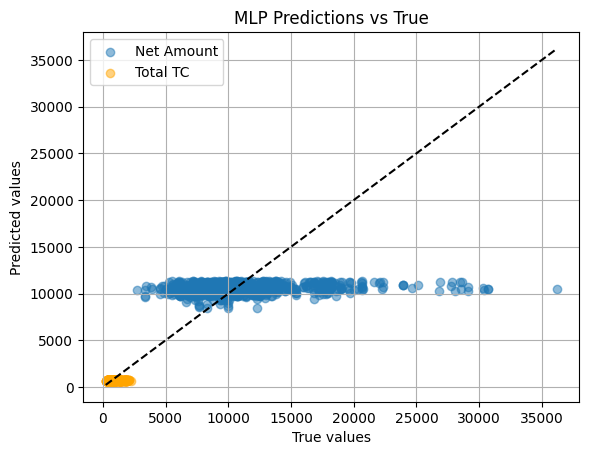

In [9]:
# # ───────────────────────────────────────────────────────────────────────────────
# # 14) Neural Network - MLP
# # ───────────────────────────────────────────────────────────────────────────────
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1) Prepare X, y (no Date here—only numeric already)
#    Assume df has columns: ['Average Daily Temperature (°C)', 'Rain_Binary', 
#                             'Total_Daily_Net_Amount','Total_Daily_TC']
df["Rain_Binary"] = df["Rain?"].map({"Yes": 1, "No": 0})
X = df[['Average Daily Temperature (°C)', 'Rain_Binary']]
y = df[['Total_Daily_Net_Amount','Total_Daily_TC']]

# 2) Split & scale
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)
scX = StandardScaler().fit(X_tr)
scy = StandardScaler().fit(y_tr)

X_tr_s = scX.transform(X_tr)
X_te_s = scX.transform(X_te)
y_tr_s = scy.transform(y_tr)
y_te_s = scy.transform(y_te)

# 3) Build & train a two-output MLP
base_mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    max_iter=1000,
    learning_rate='adaptive',
    random_state=42
)
model = MultiOutputRegressor(base_mlp)
model.fit(X_tr_s, y_tr_s)

# 4) Predict & evaluate
y_pred_s = model.predict(X_te_s)
y_pred   = scy.inverse_transform(y_pred_s)

rmse = np.sqrt(mean_squared_error(y_te, y_pred))
r2   = r2_score(y_te, y_pred)

print(f"Test RMSE: {rmse:.2f}, R²: {r2:.3f}")

# 5) Visualise
import matplotlib.pyplot as plt

plt.scatter(y_te.values[:, 0], y_pred[:, 0], alpha=0.5, label='Net Amount')
plt.scatter(y_te.values[:, 1], y_pred[:, 1], alpha=0.5, label='Total TC', color='orange')
plt.plot([y_te.values.min(), y_te.values.max()], [y_te.values.min(), y_te.values.max()], 'k--')

plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("MLP Predictions vs True")
plt.legend()
plt.grid(True)
plt.show()


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64, 32), 'learning_rate': 'adaptive'}
Test RMSE: 2874.08, R²: 0.023


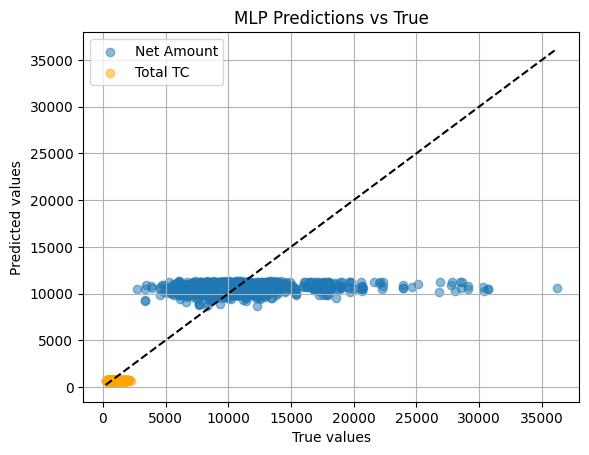

In [10]:
# # ───────────────────────────────────────────────────────────────────────────────
# # 14) Neural Network - MLP improved with GridSearchCV
# # ───────────────────────────────────────────────────────────────────────────────
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1) Prepare X, y (no Date here—only numeric already)
#    Assume df has columns: ['Average Daily Temperature (°C)', 'Rain_Binary', 
#                             'Total_Daily_Net_Amount','Total_Daily_TC']
df["Rain_Binary"] = df["Rain?"].map({"Yes": 1, "No": 0})
X = df[['Average Daily Temperature (°C)', 'Rain_Binary']]
y = df[['Total_Daily_Net_Amount','Total_Daily_TC']]

# 2) Split & scale
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)
scX = StandardScaler().fit(X_tr)
scy = StandardScaler().fit(y_tr)

X_tr_s = scX.transform(X_tr)
X_te_s = scX.transform(X_te)
y_tr_s = scy.transform(y_tr)
y_te_s = scy.transform(y_te)

from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(64,32), (128,64,32)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],  # L2 regularization
    'learning_rate': ['constant', 'adaptive']
}

grid = GridSearchCV(MLPRegressor(max_iter=1000), param_grid, cv=3)
grid.fit(X_tr_s, y_tr_s)
print(grid.best_params_)

# 3) Build & train a two-output MLP
base_mlp = MLPRegressor(hidden_layer_sizes=(64,32), activation='relu',
                        max_iter=500, random_state=42)
model = MultiOutputRegressor(base_mlp)
model.fit(X_tr_s, y_tr_s)

# 4) Predict & evaluate
y_pred_s = model.predict(X_te_s)
y_pred   = scy.inverse_transform(y_pred_s)

rmse = np.sqrt(mean_squared_error(y_te, y_pred))
r2   = r2_score(y_te, y_pred)

print(f"Test RMSE: {rmse:.2f}, R²: {r2:.3f}")

# 5) Visualise
import matplotlib.pyplot as plt

plt.scatter(y_te.values[:, 0], y_pred[:, 0], alpha=0.5, label='Net Amount')
plt.scatter(y_te.values[:, 1], y_pred[:, 1], alpha=0.5, label='Total TC', color='orange')
plt.plot([y_te.values.min(), y_te.values.max()], [y_te.values.min(), y_te.values.max()], 'k--')

plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("MLP Predictions vs True")
plt.legend()
plt.grid(True)
plt.show()

# somehow worse?

Epoch 1/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9957 - mae: 0.6588 - val_loss: 1.0879 - val_mae: 0.6692
Epoch 2/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9181 - mae: 0.6383 - val_loss: 1.0746 - val_mae: 0.6893
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0299 - mae: 0.6663 - val_loss: 1.0830 - val_mae: 0.6718
Epoch 4/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0028 - mae: 0.6592 - val_loss: 1.0818 - val_mae: 0.6733
Epoch 5/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9707 - mae: 0.6473 - val_loss: 1.0824 - val_mae: 0.6738
Epoch 6/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9768 - mae: 0.6524 - val_loss: 1.0779 - val_mae: 0.6812
Epoch 7/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0674 - mae: 0.6769 - val_loss: 1.0776 - val_mae: 0.6876
Epoch 8/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9155 - mae: 0.6381 - val_loss: 1.0763 - val_mae: 0.6869
Epoch 9/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

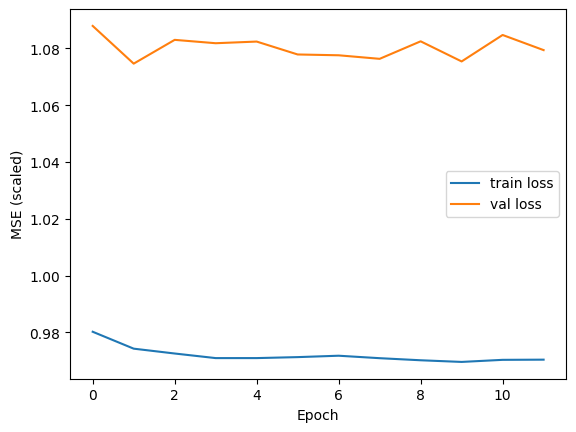

In [15]:
# ───────────────────────────────────────────────────────────────────────────────
# 14) Neural Network - TensorFlow
# ───────────────────────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# ─── 1) BUILD YOUR DATAFRAME ────────────────────────────────────────────────────
# Assume `df` has columns:
#   "Total_Daily_Net_Amount", "Total_Daily_TC", "Average Daily Temperature (°C)", "Rain?" (Yes/No)
# First we map Rain? → binary
df["Rain_Binary"] = df["Rain?"].map({"No": 0, "Yes": 1})

# Features and targets
X = df[["Average Daily Temperature (°C)", "Rain_Binary"]].values
y = df[["Total_Daily_Net_Amount", "Total_Daily_TC"]].values

# ─── 2) TRAIN/TEST SPLIT & SCALING ───────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# It often helps to scale both features and continuous targets for NN training
scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train)

X_train_s = scaler_X.transform(X_train)
X_test_s  = scaler_X.transform(X_test)

y_train_s = scaler_y.transform(y_train)
y_test_s  = scaler_y.transform(y_test)

# ─── 3) DEFINE & COMPILE THE MODEL ──────────────────────────────────────────────
model = Sequential([
    Dense(64, activation="relu", input_shape=(X_train_s.shape[1],)),
    Dense(32, activation="relu"),
    Dense(2,   activation="linear"),  # two outputs: [Net_Amount, TC]
])

model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

# ─── 4) TRAIN ────────────────────────────────────────────────────────────────────
history = model.fit(
    X_train_s, y_train_s,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10, restore_best_weights=True
        )
    ],
    verbose=1
)

# ─── 5) EVALUATE & PREDICT ──────────────────────────────────────────────────────
loss, mae = model.evaluate(X_test_s, y_test_s, verbose=0)
print(f"Test   MSE: {loss:.2f},  MAE: {mae:.2f} (scaled units)")

# Get scaled predictions and invert the scaling
y_pred_s = model.predict(X_test_s)
y_pred   = scaler_y.inverse_transform(y_pred_s)

# If you want RMSE or R² in original units:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

r2   = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse:.2f},  R²: {r2:.3f}")

# ─── 6) PLOT LOSS CURVES (OPTIONAL) ───────────────────────────────────────────────
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("MSE (scaled)")
plt.legend()
plt.show()
